In [1]:
################################################################################
######################   UsedCarPrices_CarGurus  ###############################
######################   Regression - Nonlinear  ###############################
######################    Catboost HPO GPU       ###############################
################################################################################

In [2]:
!pip install catboost
!pip install shap
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
import joblib
from hyperopt import STATUS_OK
from catboost import CatBoostRegressor
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin, tpe, Trials
import csv
from datetime import datetime, timedelta
from timeit import default_timer as timer
import ast
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap 

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Data/

/content/drive/MyDrive/UsedCarsCarGurus/Data


In [5]:
# Set seed 
seed_value = 42
os.environ['UsedCarsCarGurus_CatboostGPU'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [6]:
# Read data
df = pd.read_csv('usedCars_final.csv', low_memory=False)

In [7]:
# Convert data types
df = df.copy()
df['year'] = df['year'].astype(str)
df['listed_date_yearMonth'] = df['listed_date_yearMonth'].astype(str)

In [8]:
# Prepare for partitioning data
X = df.drop(['price'],axis=1)
y = df['price']

In [9]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = seed_value)

In [10]:
# Set categorical variables for Catboost
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [11]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Results


In [12]:
################################################################################
######################    Catboost HPO GPU    ##################################
######################       100 trials       ##################################
################################################################################
# Define the number of trials
NUM_EVAL = 100

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=10, shuffle=True, random_state=seed_value)

# Define parameter grid
catboost_tune_kwargs= {
    'iterations': hp.choice('iterations', np.arange(100, 500, dtype=int)),
    'depth': hp.choice('depth', np.arange(3, 10, dtype=int)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1e-2, 1e0), 
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.3),                              
    'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(2, 20, dtype=int)),
    'one_hot_max_size': hp.choice('one_hot_max_size', np.arange(2, 20, dtype=int)),  
    }

# Define a function for optimization of hyperparameters
def catboost_hpo(config):
    """Catboost HPO"""
    
    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['iterations'] = int(config['iterations'])   
    
    # Start hyperopt at 3 for max_depth   
    config['depth'] = int(config['depth']) + 3
 
    # Define model type
    cat = CatBoostRegressor(
        cat_features=categorical_features_indices,
        random_state=seed_value,
        loss_function='RMSE', 
        early_stopping_rounds=10,
        rsm=1,
        task_type='GPU', 
        logging_level='Silent',
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(cat, X_train, y_train, 
                              scoring='neg_root_mean_squared_error', 
                              cv=kfolds)
    
    run_time = timer() - start
    rmse = np.mean(scores)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([rmse, config, ITERATION, run_time])
    
    return {'loss': rmse, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}   


# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = 'Catboost_trials_100_GPU_TimeCategories.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [13]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))

best_param = fmin(catboost_hpo, catboost_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_trials,
                  rstate= np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-12 03:43:32.231298
100%|██████████| 100/100 [3:02:30<00:00, 109.51s/it, best loss: 2439.777766863745]
Start Time           2022-02-12 03:43:32.231298
End Time             2022-02-12 06:46:03.352844
3:02:31


In [14]:
# Sort the trials with lowest loss (lowest RMSE) first
bayesOpt_trials_results = sorted(bayesOpt_trials.results, 
                                 key = lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

Top two trials with the lowest loss (lowest RMSE)
[{'loss': 2439.777766863745, 'params': {'depth': 12, 'iterations': 493, 'l2_leaf_reg': 0.5379227292967748, 'learning_rate': 0.1269066668892665, 'min_data_in_leaf': 19, 'one_hot_max_size': 5}, 'iteration': 28, 'train_time': 393.6207407290003, 'status': 'ok'}, {'loss': 2442.3104417900786, 'params': {'depth': 12, 'iterations': 484, 'l2_leaf_reg': 0.3986443316052413, 'learning_rate': 0.10057648712678469, 'min_data_in_leaf': 8, 'one_hot_max_size': 15}, 'iteration': 82, 'train_time': 119.393651366001, 'status': 'ok'}]


In [15]:
# Access results
results = pd.read_csv('Catboost_trials_100_GPU_TimeCategories.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Model_PKL/

In [16]:
# Re-create the best model and train on the training data
best_bayes_model = CatBoostRegressor(loss_function='RMSE',
                                     cat_features=categorical_features_indices, 
                                     early_stopping_rounds=10, 
                                     rsm=1, 
                                     task_type='GPU', 
                                     logging_level='Silent', 
                                     random_state=seed_value,
                                     **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train, plot=True)

# Save model
Pkl_Filename = 'Catboost_HPO_trials100_GPU_TimeCategories.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_trials100_GPU_TimeCategories.pkl')
# print(model)
# =============================================================================

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [17]:
print('\nModel Metrics for Catboost HPO UsedCars_CarGurus 100 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))



Model Metrics for Catboost HPO UsedCars_CarGurus 100 GPU trials
MAE train: 1390.334, test: 1774.804
MSE train: 3478551.184, test: 5800173.092
RMSE train: 1865.087, test: 2408.355
R^2 train: 0.962, test: 0.937


In [18]:
# Evaluate on the testing data 
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 5800173.09217 MSE on the test set.
This was achieved after 28 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/bayesParams/

In [19]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_Catboost_HPO_100_GPU_TimeCategories.csv', 
                    index = False)

In [20]:
# Convert data types for graphing
bayes_params['depth'] = bayes_params['depth'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['l2_leaf_reg'] = bayes_params['l2_leaf_reg'].astype('float64')
bayes_params['min_data_in_leaf'] = bayes_params['min_data_in_leaf'].astype('float64')
bayes_params['one_hot_max_size'] = bayes_params['one_hot_max_size'].astype('float64')

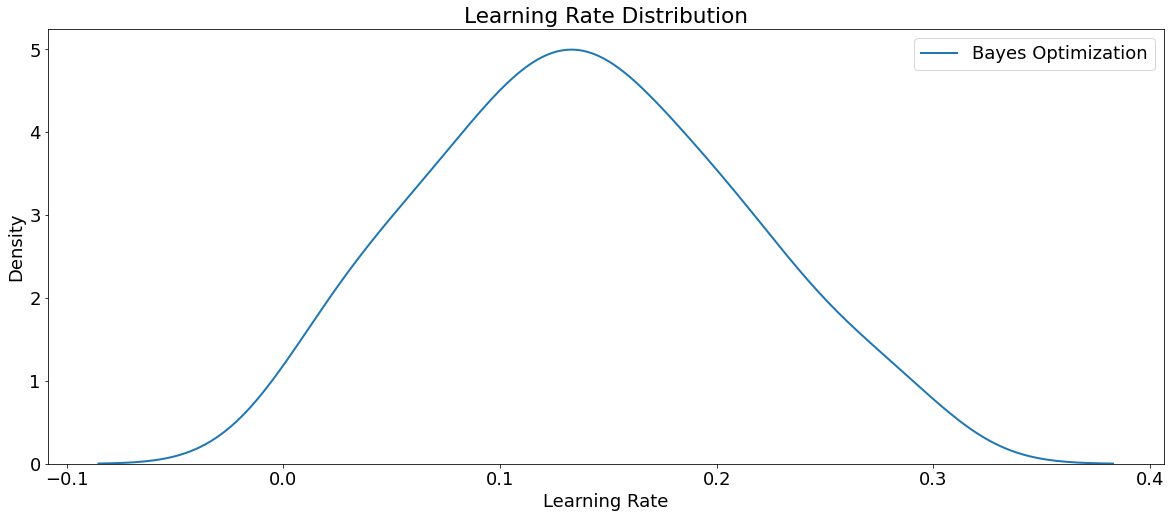

In [21]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

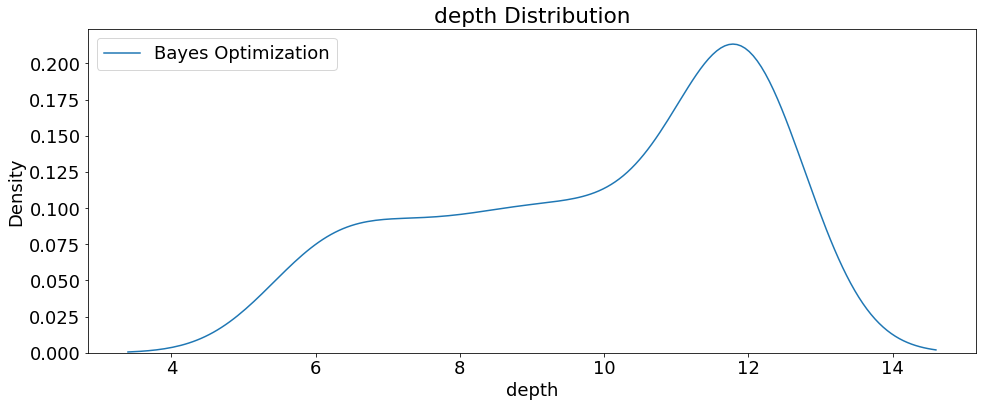

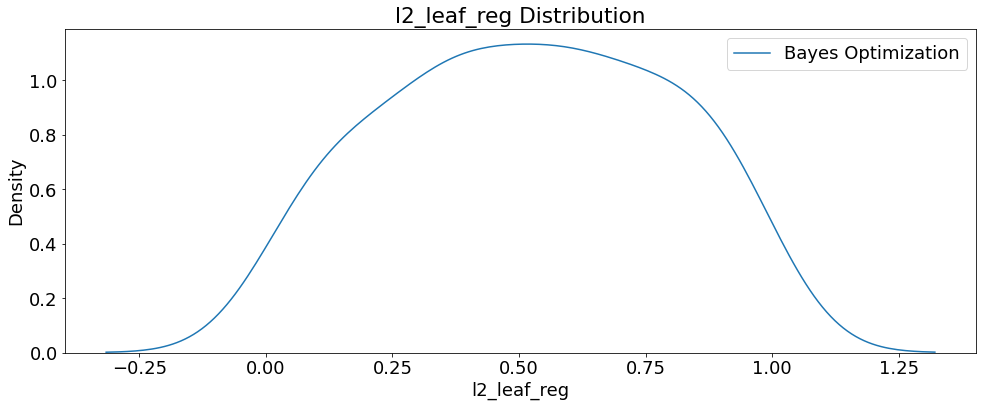

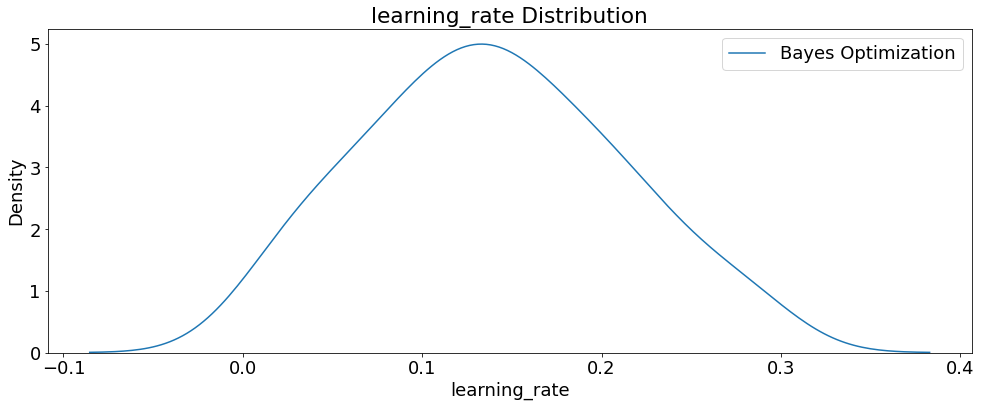

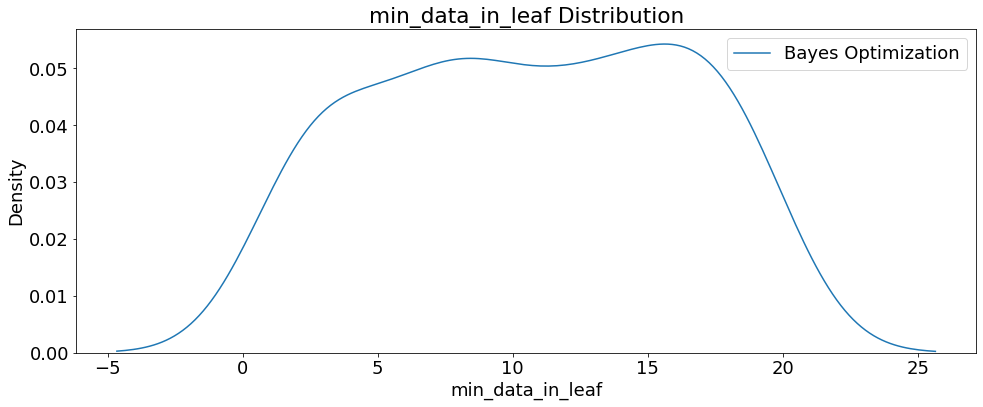

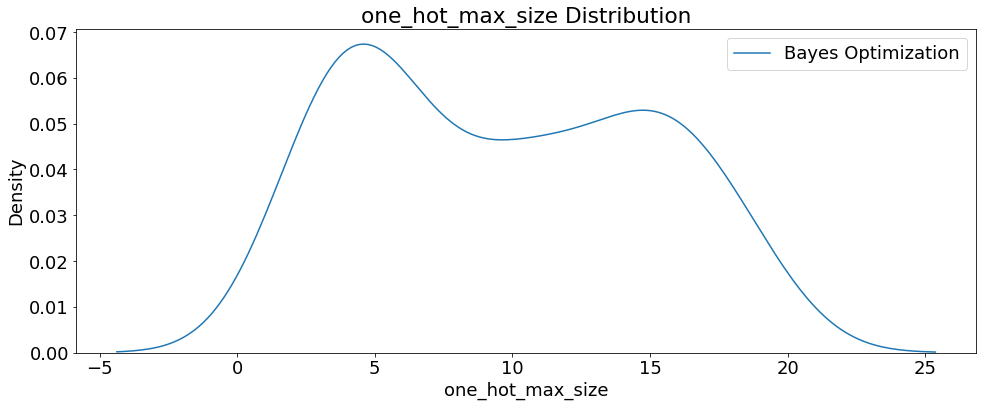

<Figure size 1008x432 with 0 Axes>

In [22]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'iterations']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label = 'Bayes Optimization')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


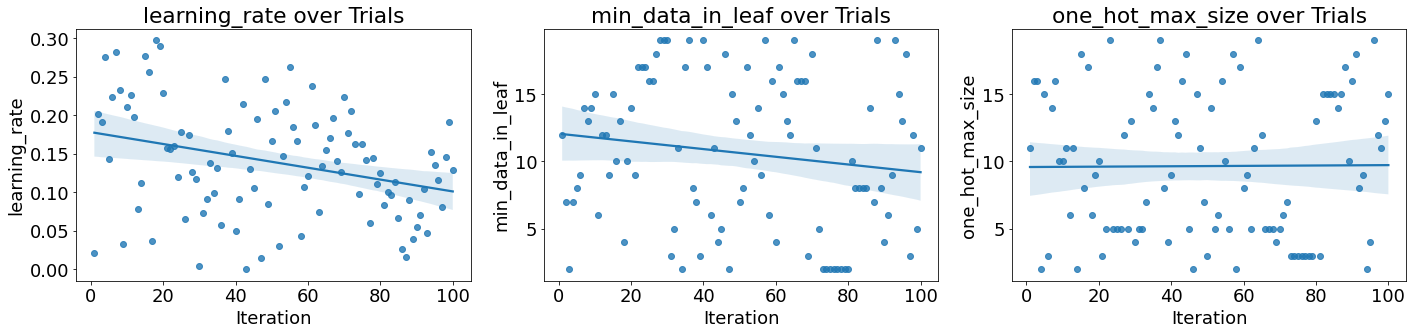

In [23]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'one_hot_max_size']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


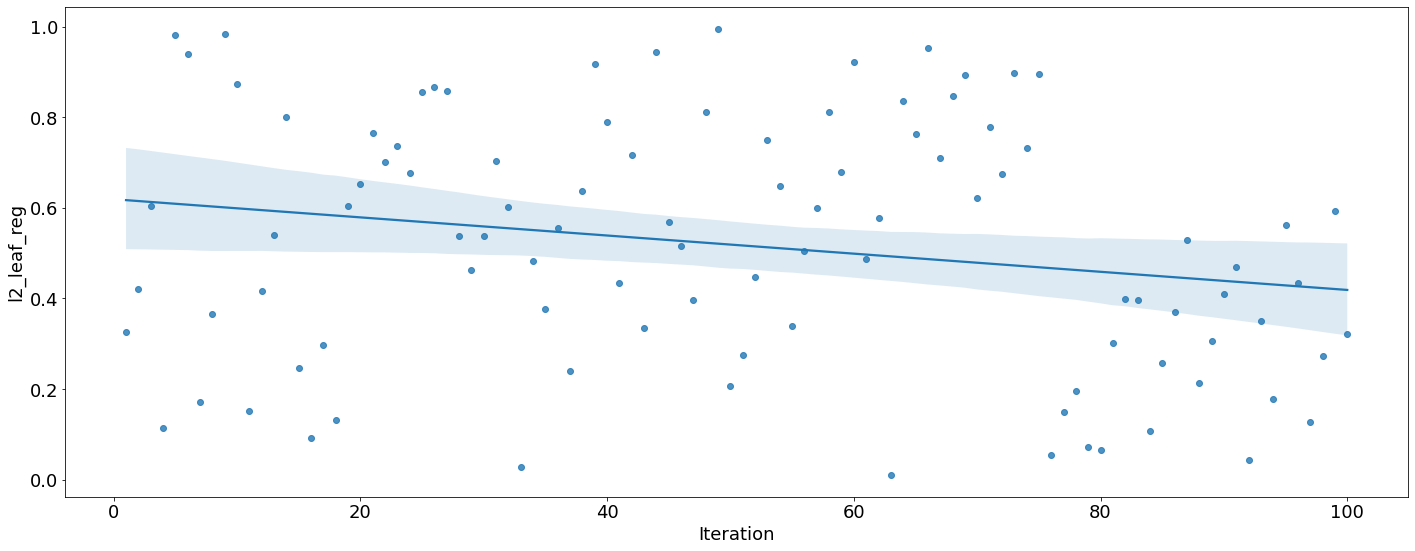

In [24]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data = bayes_params, label = 'Bayes Optimization') 
ax.set(xlabel = 'Iteration', ylabel = 'l2_leaf_reg')                 
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/Catboost/Model_Explanations/

In [25]:
# Define function for feature importance plot
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette='cool')
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

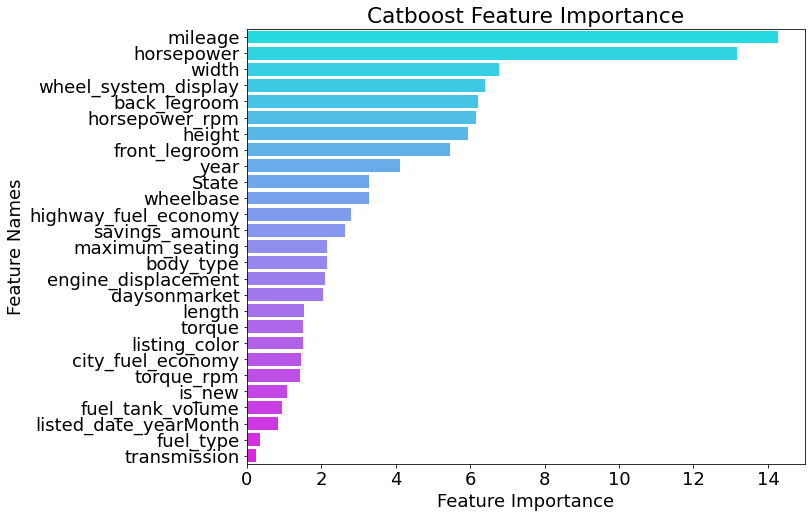

In [26]:
# Plot the feature importance from best model result
my_dpi=96
plot_feature_importance(best_bayes_model.get_feature_importance(), X_train.columns, 
                        'Catboost')

plt.savefig('Catboost_HPO_100_GPU_FeatureImportance_TimeCategories.png', dpi=my_dpi * 10)

In [27]:
# Define function for feature importance csv
def feature_importance(importance,names):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.to_csv(a, index = False)

In [28]:
# Save feature importance of best model
a = 'Catboost_HPO_100_GPU_FeatureImportance_TimeCategories.csv'
feature_importance(best_bayes_model.get_feature_importance(), X_train.columns)

In [29]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

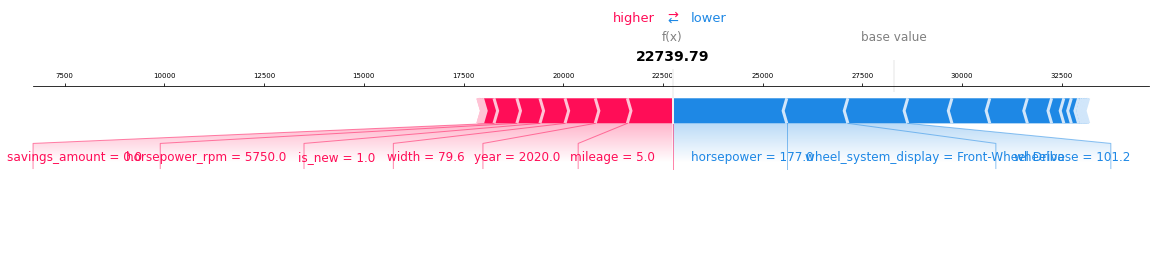

In [30]:
# Visualize the first prediction's explanation
#fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                show=False, matplotlib=True).savefig('Catboost_HPO_100_GPU_ShapForcePlot_TrainSet_TimeCategories.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

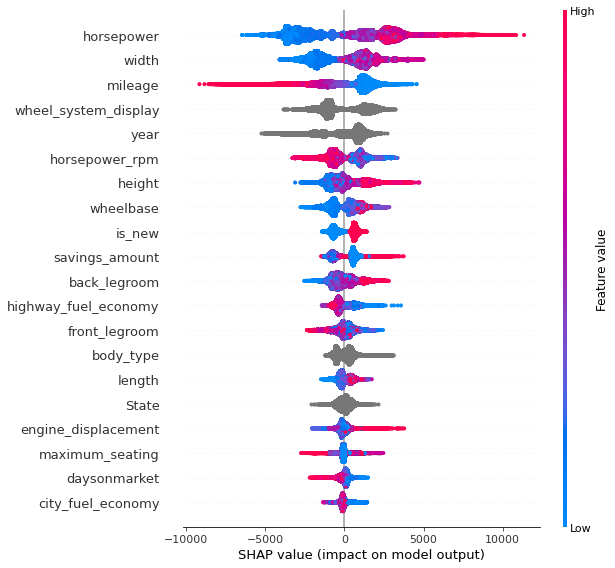

In [31]:
# Training Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('Catboost_HPO_100_GPU_ShapSummary_TrainSet_TimeCategories.png', dpi=my_dpi, 
            bbox_inches='tight')

In [32]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test)

<Figure size 432x288 with 0 Axes>

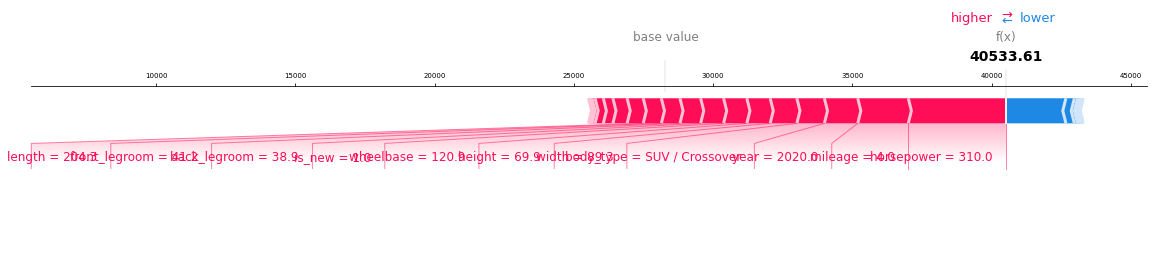

In [33]:
# Visualize the first prediction's explanation
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], 
                show=False, matplotlib=True).savefig('Catboost_HPO_100_GPU_ShapForcePlot_TestSet_TimeCategories.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

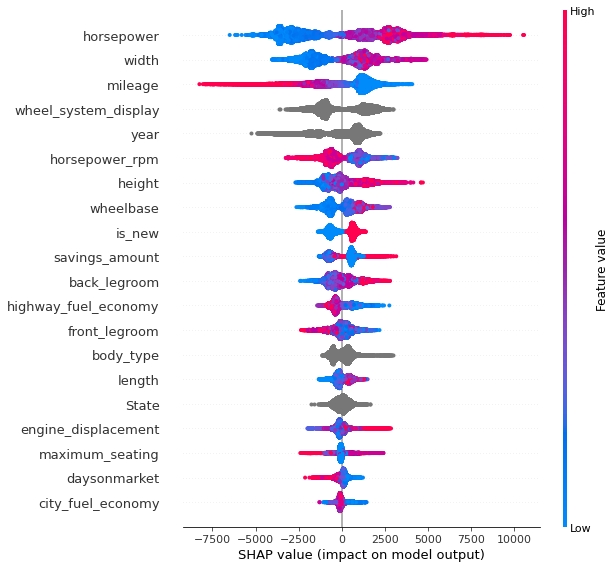

In [34]:
# Test Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('Catboost_HPO_100_GPU_ShapSummary_TestSet_TimeCategories.png', dpi=my_dpi, 
            bbox_inches='tight')